# Evaluate the performance of the different models by using a sliding window approach

Steps:
1. Harmonize the predictions to have the same format
2. Extract the frequencies using a sliding window approach
3. Evaluate the performance of the models
4. Visualize the results

## Step 1: Harmonize the predictions

In [1]:
import numpy as np
import pandas as pd
import respiration.utils as utils

signals_dir = utils.dir_path('outputs', 'signals')

In [2]:
raft_file = utils.join_paths(signals_dir, 'raft_predictions.csv')
raft_predictions = pd.read_csv(raft_file)
raft_predictions['signal'] = raft_predictions['signal_v'].apply(eval).apply(np.array)

# Only keep the chest roi predictions
raft_predictions = raft_predictions[raft_predictions['roi'] == 'chest']

# Only keep the columns that are needed
raft_predictions = raft_predictions[['subject', 'setting', 'model', 'signal']]

raft_predictions.head()

,subject,setting,model,signal
1,Proband01,101_natural_lighting,raft_large,"[-0.046315472573041916, -0.08250490576028824, ..."
4,Proband01,101_natural_lighting,raft_small,"[-0.031725313514471054, -0.021138720214366913,..."
7,Proband02,101_natural_lighting,raft_large,"[0.004266717471182346, -0.023671478033065796, ..."
10,Proband02,101_natural_lighting,raft_small,"[-0.01642800122499466, 0.0195891335606575, 0.0..."
13,Proband03,101_natural_lighting,raft_large,"[0.0041928417049348354, -0.011556083336472511,..."


In [3]:
pretrained_file = utils.join_paths(signals_dir, 'pretrained_predictions.csv')
pretrained_predictions = pd.read_csv(pretrained_file)
pretrained_predictions['signal'] = pretrained_predictions['signal'].apply(eval).apply(np.array)

# Only keep the columns that are needed
pretrained_predictions = pretrained_predictions[['subject', 'setting', 'model', 'signal']]

pretrained_predictions.head()

,subject,setting,model,signal
0,Proband01,101_natural_lighting,mtts_can,"[0.554201602935791, 0.9685323238372803, 1.1623..."
1,Proband01,101_natural_lighting,big_small,"[-0.005778029561042786, -0.013538409024477005,..."
2,Proband02,101_natural_lighting,mtts_can,"[0.2785760760307312, 0.1348249316215515, 0.488..."
3,Proband02,101_natural_lighting,big_small,"[-0.5870521664619446, -0.6804308891296387, -0...."
4,Proband03,101_natural_lighting,mtts_can,"[-0.07853958010673523, -0.42475640773773193, -..."


In [4]:
unsupervised_file = utils.join_paths(signals_dir, 'unsupervised_predictions.csv')
unsupervised_predictions = pd.read_csv(unsupervised_file)
unsupervised_predictions['signal'] = unsupervised_predictions['signal'].apply(eval).apply(np.array)

# Only keep the chest roi predictions
unsupervised_predictions = unsupervised_predictions[unsupervised_predictions['roi'] == 'chest']

# Rename column method to model
unsupervised_predictions.rename(columns={'method': 'model'}, inplace=True)

# Only keep the columns that are needed
unsupervised_predictions = unsupervised_predictions[['subject', 'setting', 'model', 'signal']]

unsupervised_predictions.head()

,subject,setting,model,signal
2,Proband01,101_natural_lighting,pixel_intensity,"[144.23864661654136, 144.1996992481203, 144.24..."
3,Proband01,101_natural_lighting,lucas_kanade,"[569.4346933795572, 569.3766135619596, 569.319..."
8,Proband02,101_natural_lighting,pixel_intensity,"[192.59745939192004, 192.5506039150354, 192.77..."
9,Proband02,101_natural_lighting,lucas_kanade,"[569.9889787138529, 569.9748017264346, 569.970..."
14,Proband03,101_natural_lighting,pixel_intensity,"[29.76606978879706, 29.798209366391184, 30.973..."


In [5]:
fine_tuned_path = utils.join_paths(signals_dir, 'fine_tuned_predictions.csv')

fine_tuned_prediction = pd.read_csv(fine_tuned_path)
fine_tuned_prediction['signal'] = fine_tuned_prediction['signal'].apply(eval).apply(np.array)

# Only keep the columns that are needed
fine_tuned_prediction = fine_tuned_prediction[['subject', 'setting', 'model', 'signal']]

fine_tuned_prediction.head()

,subject,setting,model,signal
0,Proband01,101_natural_lighting,BP4D_PseudoLabel_EfficientPhys,"[0.8038537502288818, 0.8904275894165039, 0.650..."
1,Proband01,101_natural_lighting,MA-UBFC_efficientphys,"[-0.24183669686317444, -0.42213234305381775, -..."
2,Proband01,101_natural_lighting,PURE_EfficientPhys,"[-0.3179636597633362, -0.40903693437576294, -0..."
3,Proband01,101_natural_lighting,SCAMPS_EfficientPhys,"[0.7190999984741211, 0.2930055856704712, 0.035..."
4,Proband01,101_natural_lighting,UBFC-rPPG_EfficientPhys,"[-0.2609124481678009, -0.4764321744441986, -0...."


In [6]:
r_ppg_path = utils.join_paths(signals_dir, 'r_ppg_predictions.csv')

r_ppg_prediction = pd.read_csv(r_ppg_path)
r_ppg_prediction['signal'] = r_ppg_prediction['signal'].apply(eval).apply(np.array)

# Only keep the columns that are needed
r_ppg_prediction = r_ppg_prediction[['subject', 'setting', 'model', 'signal']]

r_ppg_prediction.head()

,subject,setting,model,signal
0,Proband01,101_natural_lighting,BP4D_PseudoLabel_TSCAN,"[0.1003175675868988, 0.4112994968891144, 0.678..."
1,Proband01,101_natural_lighting,MA-UBFC_tscan,"[-0.5689785480499268, -0.3492545187473297, -0...."
2,Proband01,101_natural_lighting,PURE_TSCAN,"[0.2524776756763458, -0.23906010389328003, -0...."
3,Proband01,101_natural_lighting,SCAMPS_TSCAN,"[1.1077316999435425, 0.7577620148658752, -1.23..."
4,Proband01,101_natural_lighting,UBFC-rPPG_TSCAN,"[-0.0640445351600647, -0.2270553708076477, -0...."


In [7]:
predictions = pd.concat([
    raft_predictions,
    pretrained_predictions,
    unsupervised_predictions,
    fine_tuned_prediction,
    r_ppg_prediction,
])
len(predictions)

598

## Step 2: Extract the frequencies using a sliding window approach

In [8]:
from respiration.dataset import VitalCamSet

dataset = VitalCamSet()

In [9]:
import itertools
from tqdm.auto import tqdm
import respiration.analysis as analysis

# rPPG lowpass and highpass frequencies
# lowpass = 0.7
# highpass = 2.5

# Breathing lowpass and highpass frequencies
lowpass = 0.08
highpass = 0.5

subjects = predictions['subject'].unique()
settings = predictions['setting'].unique()

frequency_predictions = []

for (subject, setting) in tqdm(itertools.product(subjects, settings), total=len(subjects) * len(settings)):
    scenario_predictions = predictions[
        (predictions['subject'] == subject) &
        (predictions['setting'] == setting)]

    # Get the ground truth signal
    gt_signal = dataset.get_breathing_signal(subject, setting)

    # Remove the first entry of the ground truth signal, because the prediction is run on a time shifted input
    gt_signal = gt_signal[1:]

    # Get the ground truth frequencies over a sliding window
    gt_frequencies = analysis.sliding_window_analysis(gt_signal, 30, lowpass, highpass)

    for model in scenario_predictions['model'].unique():
        model_scenario_predictions = scenario_predictions[scenario_predictions['model'] == model]
        predicted_signal = model_scenario_predictions['signal'].values[0]
        pred_frequencies = analysis.sliding_window_analysis(predicted_signal, 30, lowpass, highpass)

        for metric in gt_frequencies:
            frequency_predictions.append({
                'subject': subject,
                'setting': setting,
                'model': model,
                'metric': metric,
                'gt_frequencies': gt_frequencies[metric],
                'pred_frequencies': pred_frequencies[metric]
            })

  0%|          | 0/26 [00:00<?, ?it/s]

In [10]:
frequencies_df = pd.DataFrame(frequency_predictions)

## Step 3: Evaluate the performance of the models

In [11]:
import scipy.stats as stats

models = frequencies_df['model'].unique()
metrics = frequencies_df['metric'].unique()

evaluation_results = []

for (model, metric) in itertools.product(models, metrics):
    model_metric_df = frequencies_df[
        (frequencies_df['model'] == model) &
        (frequencies_df['metric'] == metric)]

    # Concatenate the predicted and ground truth frequencies
    gt_frequencies = np.concatenate(model_metric_df['gt_frequencies'].values)
    pred_frequencies = np.concatenate(model_metric_df['pred_frequencies'].values)

    mae = np.mean(np.abs(gt_frequencies - pred_frequencies))
    rmse = np.sqrt(np.mean((gt_frequencies - pred_frequencies) ** 2))
    corr, p = stats.pearsonr(gt_frequencies.flatten(), pred_frequencies.flatten())

    evaluation_results.append({
        'model': model,
        'metric': metric,
        'mae': mae,
        'rmse': rmse,
        'corr': corr,
        'p': p
    })

In [12]:
evaluation_df = pd.DataFrame(evaluation_results)
evaluation_df

,model,metric,mae,rmse,corr,p
0,raft_large,cp,0.041959,0.059003,0.493570,5.978576e-144
1,raft_large,nfcp,0.065363,0.087435,-0.062784,2.377864e-03
2,raft_large,pk,0.041097,0.057903,0.524037,3.180318e-165
3,raft_large,psd,0.026211,0.049967,0.775694,0.000000e+00
4,raft_small,cp,0.044573,0.061115,0.431751,7.016024e-107
...,...,...,...,...,...,...
87,SCAMPS_DeepPhys,psd,0.090442,0.118940,0.269856,2.498066e-40
88,UBFC-rPPG_DeepPhys,cp,0.085997,0.101685,-0.064694,1.741629e-03
89,UBFC-rPPG_DeepPhys,nfcp,0.103063,0.119549,-0.069887,7.169734e-04
90,UBFC-rPPG_DeepPhys,pk,0.087322,0.104495,-0.110030,9.506665e-08


In [13]:
analysis_dir = utils.dir_path('outputs', 'analysis')
evaluation_path = utils.join_paths(analysis_dir, 'sliding_window_evaluation.csv')
evaluation_df.to_csv(evaluation_path, index=False)

In [14]:
evaluation_df[evaluation_df['metric'] == 'psd']

,model,metric,mae,rmse,corr,p
3,raft_large,psd,0.026211,0.049967,0.775694,0.000000e+00
7,raft_small,psd,0.023575,0.045254,0.821487,0.000000e+00
11,mtts_can,psd,0.129701,0.154792,-0.022364,2.795260e-01
15,big_small,psd,0.075798,0.103777,0.226342,1.446064e-28
19,pixel_intensity,psd,0.052094,0.092949,0.557117,6.407016e-191
23,lucas_kanade,psd,0.028946,0.058365,0.767945,0.000000e+00
27,BP4D_PseudoLabel_EfficientPhys,psd,0.092009,0.122817,0.162630,2.461930e-15
31,MA-UBFC_efficientphys,psd,0.105427,0.132610,0.081812,7.430292e-05
35,PURE_EfficientPhys,psd,0.087593,0.116398,0.259550,2.472658e-37
39,SCAMPS_EfficientPhys,psd,0.103020,0.130675,0.077260,1.833403e-04


## Step 4: Visualize the results

In [15]:
figure_dir = utils.dir_path('outputs', 'figures')

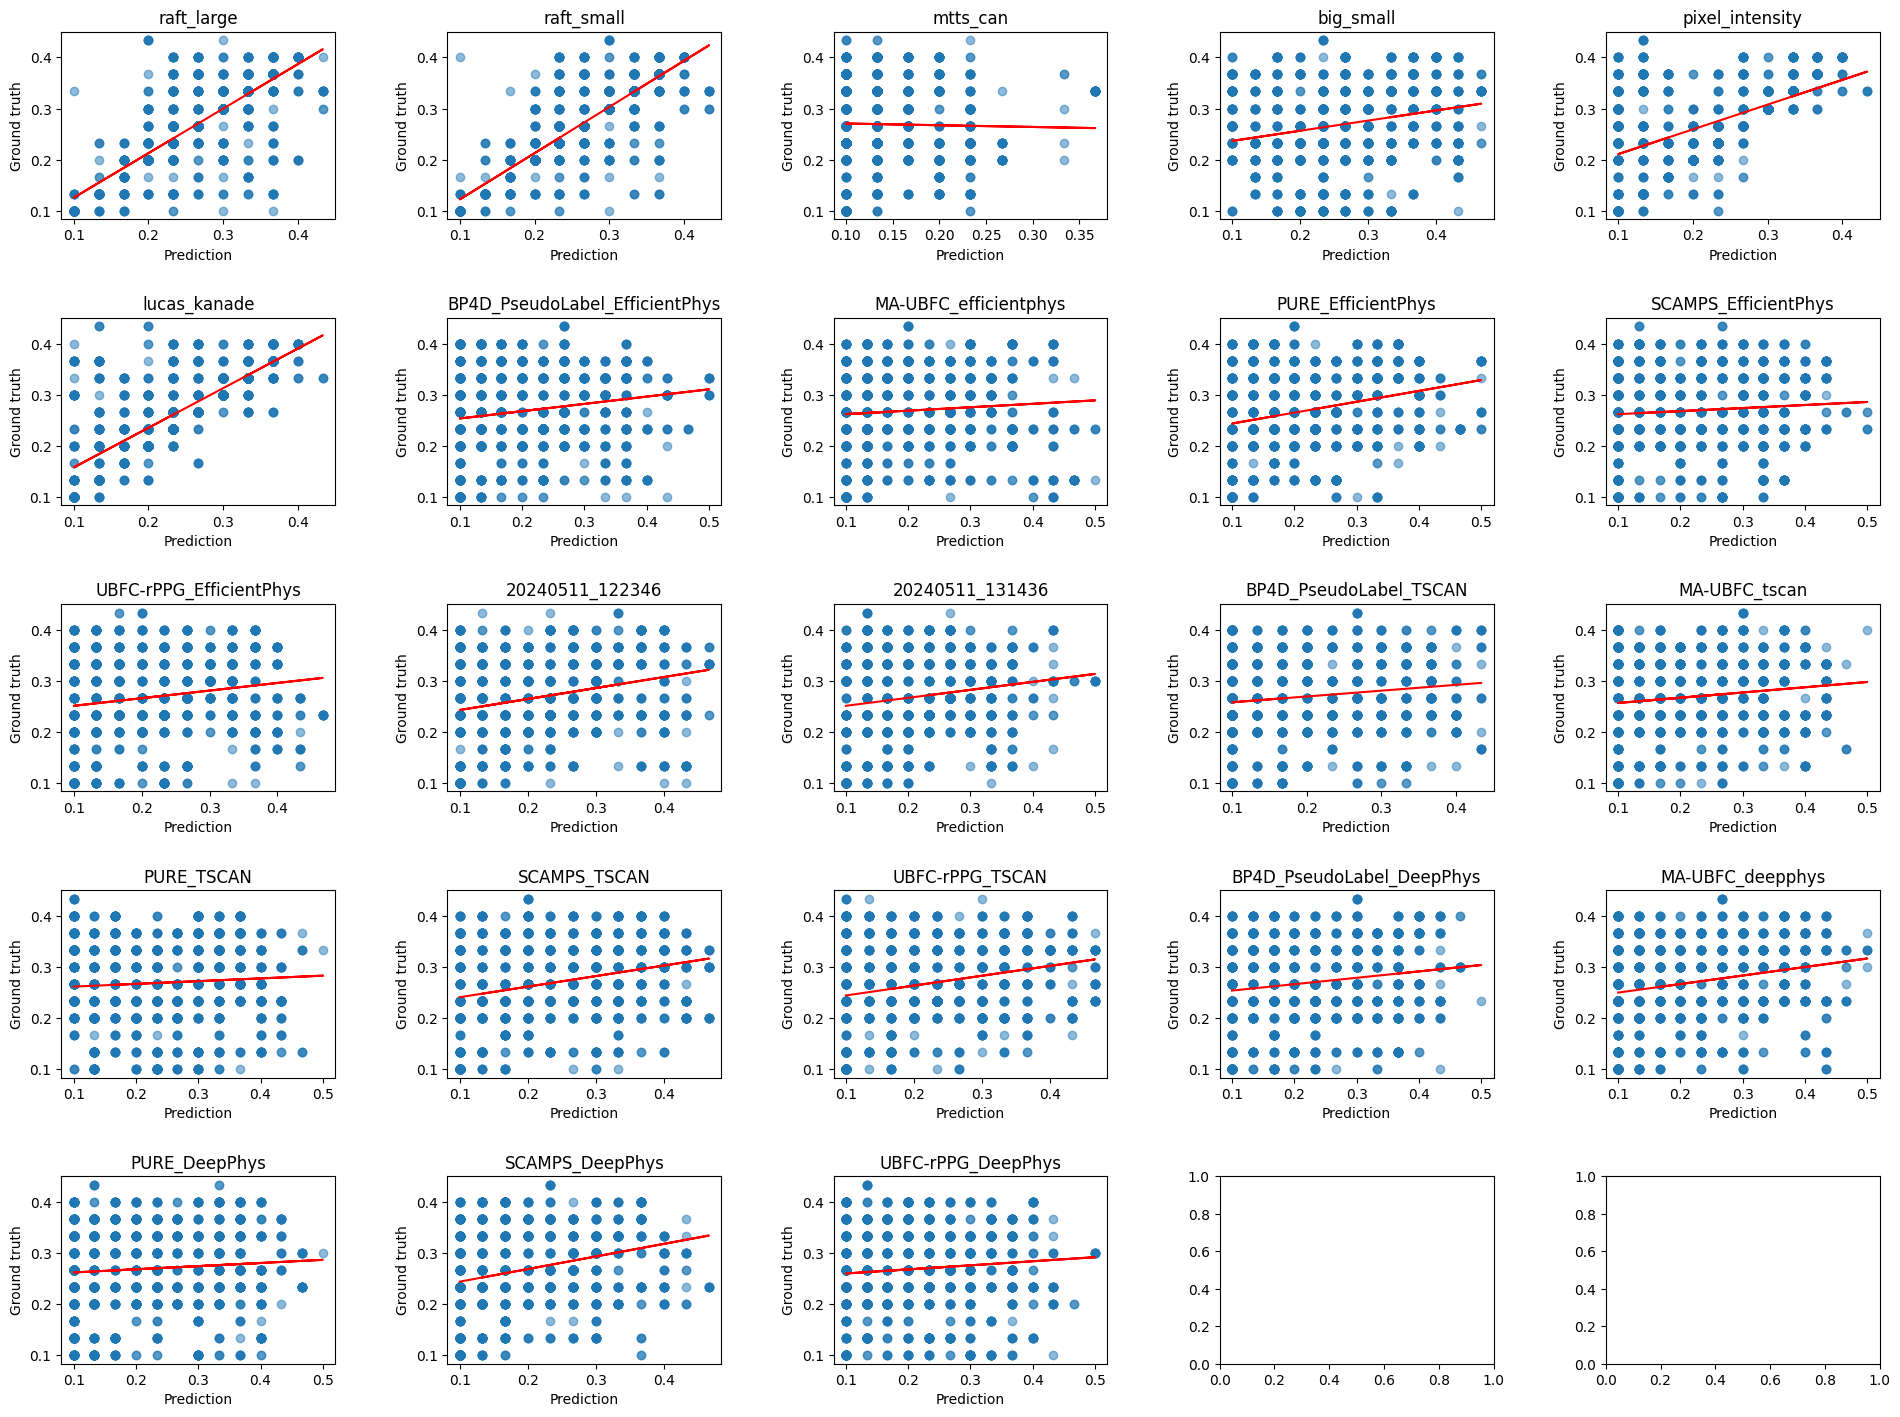

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import respiration.utils as utils

metric = 'psd'

fig, axs = plt.subplots(5, 5, figsize=(20, 15))

# Add some space between the plots
fig.tight_layout(pad=5.0)

for idx, model in enumerate(models):
    model_metric_df = frequencies_df[
        (frequencies_df['model'] == model) &
        (frequencies_df['metric'] == metric)]

    # Concatenate the predicted and ground truth frequencies
    ground_truth = np.concatenate(model_metric_df['gt_frequencies'].values)
    prediction = np.concatenate(model_metric_df['pred_frequencies'].values)

    ax = axs[idx // 5, idx % 5]

    ax.scatter(prediction, ground_truth, alpha=0.5)

    # Add a regression line
    x = prediction
    y = ground_truth
    m, b = np.polyfit(x, y, 1)
    ax.plot(x, m * x + b, color='red')

    ax.set_xlabel('Prediction')
    ax.set_ylabel('Ground truth')
    ax.set_title(model)

utils.savefig(fig, figure_dir, f'model_correlation_{metric}')